In [1]:
##########################################################################
import numpy as np
from numba import njit
import matplotlib
#matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
from scipy import ndimage
import os
import time

from emcee import EnsembleSampler
import corner
import pickle
from scipy import signal

# Convert from arcsec and deg to radians
from galario import arcsec, deg
from galario.double import chi2Image, sampleImage, get_image_size
from uvplot import COLUMNS_V0

from uvplot import UVTable
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
##########################################################################

target = 'CQ_Tau'

In [2]:
##################################
#####   IMPORT THE UVTABLE   #####
##################################

print('Importing uvtable')
uvtable_filename = target+'_galario_uvtable.txt'
u, v, Re, Im, w = np.require(np.loadtxt(uvtable_filename, unpack=True), requirements='C')
wle = 0.0009042025604668597  # in meters, read from the second line in the uvtable.txt
u /= wle
v /= wle

Importing uvtable


In [3]:
########################################
#####   DETERMINE THE IMAGE SIZE   #####
########################################

# compute the optimal image size (nxy=number of pixels, dxy=pixel size in radians)
nxy, dxy = get_image_size(u, v, verbose=True, f_min=5., f_max=2.5)

# define the image grid in radians
xarr = np.linspace(-nxy/2*dxy, nxy/2*dxy, nxy)
yarr = np.linspace(-nxy/2*dxy, nxy/2*dxy, nxy)
x,y = np.meshgrid(xarr, yarr)

dxy:5.787752e-03arcsec	nxy_MRS:8192
nxy_MRS: matrix size to have FOV > f_min * MRS, where f_min:5.0 and MRS:9.482653e+00arcsec


In [4]:
#############################################
#####   DEFINE THE 2D MODEL FUNCTIONS   #####
#############################################

# define a Gaussian ring in 2D on the image array (with numba to make it faster)
@njit(fastmath=True, parallel=True)
def ring_2D(I0,R0,width,inc_rad):
    r = ((x/np.cos(inc_rad))**2.+(y)**2.)**0.5 
    imagemap = I0 * np.exp(-((r-R0)**2.)/(2.*(width)**2.))
    return imagemap


# Define a 2D 'Gaussian' arc on the image array (with numba to make it faster)
'''
2D arc defined as a Gaussian 2D ring with an exponential cutoff on the azimuthal coordinate

theta0 = angle in deg of the central point of the arc
defined with same convention of the PA, 0=up, 90=left, 180=down, 270=right

theta_width = angle in deg of the azimuthal extension of the arc,
or better, angle after which there is the exponential cutoff
'''
@njit(fastmath=True, parallel=True)
def arc_2D(I0,R0,R_width, theta0_rad, theta_width_rad,inc_rad):
    r = ((x/np.cos(inc_rad))**2.+(y)**2.)**0.5 
    theta = np.arctan2(y,x/np.cos(inc_rad)) - theta0_rad
    for j in range(nxy):
        for k in range(nxy):
            if theta[j,k] >  np.pi:
                theta[j,k] = 2*np.pi - theta[j,k]
            if theta[j,k] <  -np.pi:
                theta[j,k] = -2*np.pi - theta[j,k]
    imagemap = I0 * np.exp(-((r-R0)**2.)/(2.*(R_width)**2.)) * np.exp(-(theta)**2./(2.*theta_width_rad**2.)) 
    return imagemap


# define the image model as sum of two rings and two arcs (with numba to make it faster)
@njit(fastmath=True, parallel=True)
def Image2D_2rings_2arcs(f1,r1,sigma1,   f2,r2,sigma2,   f_arc1,r_arc1,sigmar_arc1,th_arc1,sigmath_arc1,  f_arc2,r_arc2,sigmar_arc2,th_arc2,sigmath_arc2,   inc_rad):
    model_image = ring_2D(f1,r1,sigma1,inc_rad) + ring_2D(f2,r2,sigma2,inc_rad) + arc_2D(f_arc1,r_arc1,sigmar_arc1, th_arc1, sigmath_arc1,inc_rad) + arc_2D(f_arc2,r_arc2,sigmar_arc2, th_arc2, sigmath_arc2,inc_rad) 
    return model_image

In [71]:
f1 = 10.55
r1 = 0.28
sigma1 = 0.1

f2 = 9.27
r2 = 0.48
sigma2 = 0.18

f_arc1 = 10.4
r_arc1 = 0.3
sigmar_arc1 = 0.08
th_arc1 = 10
sigmath_arc1 = 40

f_arc2 = 10.4
r_arc2 = 0.3
sigmar_arc2 = 0.08
th_arc2 = 160
sigmath_arc2 = 30

inc =35.
PA = 55.

In [72]:
f1 = (10.0**f1) * dxy**2        # convert from log10[Jy/sr] to Jy/pixel
f2 = (10.0**f2) * dxy**2
f_arc1 = (10.**f_arc1) * dxy**2
f_arc2 = (10.**f_arc2) * dxy**2

# convert to radians
r1 *= arcsec
r2 *= arcsec
r_arc1 *= arcsec
r_arc2 *= arcsec
sigma1 *= arcsec
sigma2 *= arcsec
sigmar_arc1 *= arcsec
sigmar_arc2 *= arcsec

th_arc1 = (90+th_arc1) * deg
th_arc2 = (90+th_arc2) * deg
sigmath_arc1 *= deg
sigmath_arc2 *= deg

inc *= deg

In [73]:
model_image = Image2D_2rings_2arcs(f1,r1,sigma1,   f2,r2,sigma2,   f_arc1,r_arc1,sigmar_arc1,th_arc1,sigmath_arc1,  f_arc2,r_arc2,sigmar_arc2,th_arc2,sigmath_arc2,   inc)

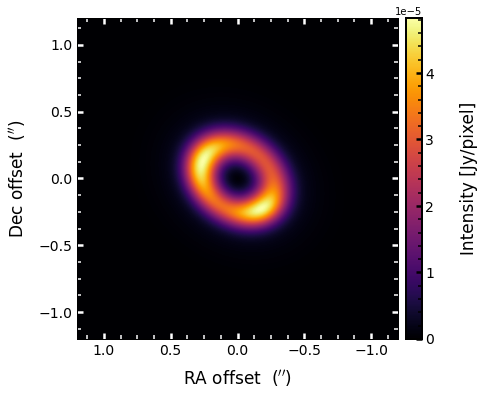

In [74]:
fig= plt.figure(figsize=(7,5.9))
ax =fig.add_subplot(111)

rotate_img = ndimage.rotate(model_image, -PA, reshape=False)
plt.imshow(rotate_img, cmap = 'inferno', extent=[nxy/2*dxy/arcsec, -nxy/2*dxy/arcsec, -nxy/2*dxy/arcsec, nxy/2*dxy/arcsec],origin='lower')

cbar = plt.colorbar(pad=0.02)
cbar.outline.set_linewidth(2)
cbar.ax.tick_params(which='major', labelsize=14,width=2.5, length=6,direction='in')
cbar.ax.tick_params(which='minor', labelsize=14,width=1.5, length=4,direction='in')
cbar.set_label('Intensity [Jy/pixel]', fontsize = 17, labelpad=26)
cbar.ax.minorticks_on()

lim = 1.2
ax.set_xlim(lim,-lim)
ax.set_ylim(-lim,lim)

index_ticks = 0.5
ax.xaxis.set_major_locator(MultipleLocator(index_ticks))
ax.xaxis.set_minor_locator(MultipleLocator(index_ticks/4))
ax.yaxis.set_major_locator(MultipleLocator(index_ticks))
ax.yaxis.set_minor_locator(MultipleLocator(index_ticks/4)) 
ax.tick_params(which='major',axis='both',right=True,top=True, labelsize=14, pad=5,width=2.5, length=6,direction='in',color='w')
ax.tick_params(which='minor',axis='both',right=True,top=True, labelsize=14, pad=5,width=1.5, length=4,direction='in',color='w')
ax.set_xlabel('RA offset  ($^{\prime\prime}$)', fontsize = 17, labelpad=10)
ax.set_ylabel('Dec offset  ($^{\prime\prime}$)', fontsize = 17, labelpad=10)

for side in ax.spines.keys():  # 'top', 'bottom', 'left', 'right'
    ax.spines[side].set_linewidth(1)
    
#plt.savefig('Model_Image2D_1ring_1arc_'+str(int(nwalkers))+'walker_'+str(int(nsteps))+'steps.pdf', bbox_inches='tight')           

In [75]:
dRA = -0.0056
dDec = -0.0053

dRA *= arcsec
dDec *= arcsec

In [76]:
vis_mod = sampleImage(model_image, dxy, u, v, PA=PA, dRA=dRA, dDec=dDec, origin='lower')

Masking 0 uv bins
Masking 0 uv bins


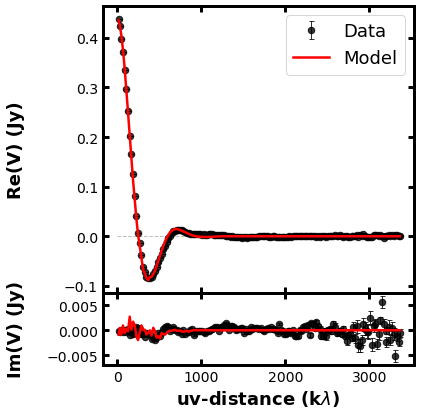

In [77]:

uvbin_size = 20e3     # uv-distance bin, units: wle

# observations uv-plot
uv = UVTable(uvtable=[u*wle, v*wle, Re, Im, w], wle=wle, columns=COLUMNS_V0)
uv.apply_phase(-dRA, -dDec)         # center the source on the phase center
uv.deproject(inc, PA)
axes = uv.plot(linestyle='.', color='k', label='Data', uvbin_size=uvbin_size, linewidth=1, alpha=0.8)

# model uv-plot
uv_mod = UVTable(uvtable=[u*wle, v*wle, vis_mod.real, vis_mod.imag, w], wle=wle, columns=COLUMNS_V0)
uv_mod.apply_phase(-dRA, -dDec)     # center the source on the phase center
uv_mod.deproject(inc, PA)
uv_mod.plot(axes=axes, linestyle='-', color='r', label='Model', yerr=False, uvbin_size=uvbin_size)

axes[0].hlines(0,0,3000, linewidth=1, alpha=0.5, color='gray', linestyle='dashed')
axes[1].hlines(0,0,3000, linewidth=1, alpha=0.5, color='gray', linestyle='dashed')


axes[0].legend(fontsize=18, frameon=True)
for side in axes[0].spines.keys():  # 'top', 'bottom', 'left', 'right'
    axes[0].spines[side].set_linewidth(3)

for side in axes[1].spines.keys():  # 'top', 'bottom', 'left', 'right'
    axes[1].spines[side].set_linewidth(3)
axes[0].tick_params(which='both',right=True,top=True, width=3, length=6,labelsize=14, direction='in',pad=5)
axes[1].tick_params(which='both',right=True,top=True, width=3, length=6,labelsize=14, direction='in',pad=5)


Masking 2 uv bins


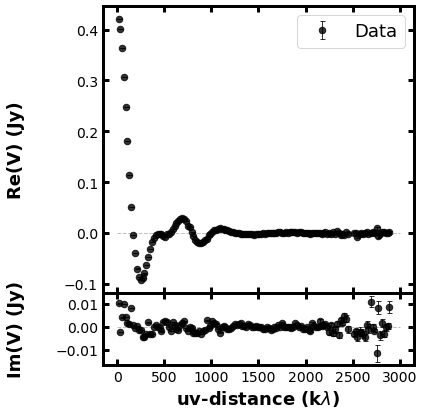

In [24]:

uvbin_size = 20e3     # uv-distance bin, units: wle

# observations uv-plot
uv = UVTable(uvtable=[u*wle, v*wle, Re, Im, w], wle=wle, columns=COLUMNS_V0)
uv.apply_phase(-dRA, -dDec)         # center the source on the phase center
uv.deproject(inc, PA)
axes = uv.plot(linestyle='.', color='k', label='Data', uvbin_size=uvbin_size, linewidth=1, alpha=0.8)

axes[0].hlines(0,0,3000, linewidth=1, alpha=0.5, color='gray', linestyle='dashed')
axes[1].hlines(0,0,3000, linewidth=1, alpha=0.5, color='gray', linestyle='dashed')


axes[0].legend(fontsize=18, frameon=True)
for side in axes[0].spines.keys():  # 'top', 'bottom', 'left', 'right'
    axes[0].spines[side].set_linewidth(3)

for side in axes[1].spines.keys():  # 'top', 'bottom', 'left', 'right'
    axes[1].spines[side].set_linewidth(3)
axes[0].tick_params(which='both',right=True,top=True, width=3, length=6,labelsize=14, direction='in',pad=5)
axes[1].tick_params(which='both',right=True,top=True, width=3, length=6,labelsize=14, direction='in',pad=5)


In [25]:
u

array([-191116.24712805, -188498.24967538, -153611.37655736, ...,
       -126985.7054383 ,  276246.2869725 ,  149260.80272358])

In [26]:
Re

array([-0.00161448, -0.02154501, -0.1019101 , ...,  0.02186832,
       -0.03068409, -0.02213448])

In [27]:
vis_mod.real

array([-6.20523447e+09, -4.54636179e+09, -1.12245709e+10, ...,
        8.21133200e+08, -4.33521236e+09, -2.48198444e+09])

Masking 2 uv bins
Masking 2 uv bins


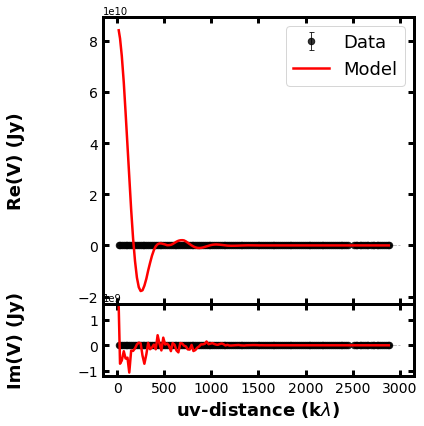

In [28]:

uvbin_size = 20e3     # uv-distance bin, units: wle

# observations uv-plot
uv = UVTable(uvtable=[u*wle, v*wle, Re, Im, w], wle=wle, columns=COLUMNS_V0)
uv.apply_phase(-dRA, -dDec)         # center the source on the phase center
uv.deproject(inc, PA)
axes = uv.plot(linestyle='.', color='k', label='Data', uvbin_size=uvbin_size, linewidth=1, alpha=0.8)

# model uv-plot
uv_mod = UVTable(uvtable=[u*wle, v*wle, vis_mod.real, vis_mod.imag, w], wle=wle, columns=COLUMNS_V0)
uv_mod.apply_phase(-dRA, -dDec)     # center the source on the phase center
uv_mod.deproject(inc, PA)
uv_mod.plot(axes=axes, linestyle='-', color='r', label='Model', yerr=False, uvbin_size=uvbin_size)

axes[0].hlines(0,0,3000, linewidth=1, alpha=0.5, color='gray', linestyle='dashed')
axes[1].hlines(0,0,3000, linewidth=1, alpha=0.5, color='gray', linestyle='dashed')


axes[0].legend(fontsize=18, frameon=True)
for side in axes[0].spines.keys():  # 'top', 'bottom', 'left', 'right'
    axes[0].spines[side].set_linewidth(3)

for side in axes[1].spines.keys():  # 'top', 'bottom', 'left', 'right'
    axes[1].spines[side].set_linewidth(3)
axes[0].tick_params(which='both',right=True,top=True, width=3, length=6,labelsize=14, direction='in',pad=5)
axes[1].tick_params(which='both',right=True,top=True, width=3, length=6,labelsize=14, direction='in',pad=5)
